In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [2]:
from glob import glob

img_paths = []

for img_path in glob("/kaggle/input/utkface-new/UTKFace/*.jpg"):
    img_paths.append(img_path)

In [3]:
len(img_paths)

23708

In [4]:
X = []
Y = []
from tqdm import tqdm

for path in tqdm(img_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128)) 
    img = np.array(img)/ 255
    X.append(img)
    
    y = str(path).split("/")[-1].split("_")[0:2]
    Y.append(y)

100%|██████████| 23708/23708 [02:50<00:00, 139.13it/s]


In [5]:
X_test = []
Y_test = []


test_image_paths = []

for img_path in glob("/kaggle/input/utkface-new/crop_part1/*.jpg"):
    test_image_paths.append(img_path)

for path in tqdm(test_image_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128)) 
    img = np.array(img)/ 255
    X_test.append(img)
    
    y = str(path).split("/")[-1].split("_")[0:2]
    Y_test.append(y)

100%|██████████| 9780/9780 [01:21<00:00, 120.63it/s]


In [6]:
X = np.array(X)
Y = np.array(Y)
len(X), len(Y)

(23708, 23708)

In [7]:
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [8]:
X_train = X

In [9]:
len(X_train), len(X_test)

(23708, 9780)

In [10]:
Y_train = np.array(Y).astype(np.float32)

In [11]:
Y_train_age = Y_train[:, 0]
Y_train_gender = Y_train[:, 1]

In [12]:
Y_test = np.array(Y_test).astype(np.float32)
Y_test_age = Y_test[:, 0]
Y_test_gender = Y_test[:, 1]

[26.  1.]


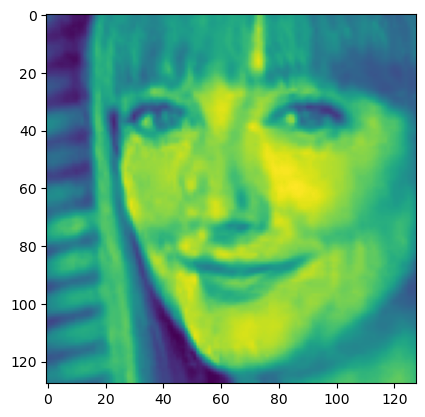

In [13]:
import random
rand_num = random.choice(range(len(X_train)))
plt.imshow(X_train[rand_num])
print(Y_train[rand_num])

[75.  0.]


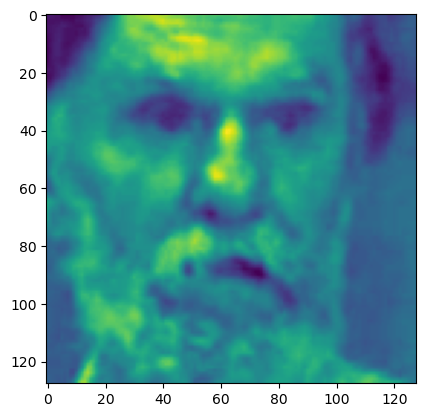

In [14]:
plt.imshow(X_test[rand_num])
print(Y_test[rand_num])

In [15]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 1),
    alpha=1.0,
    include_top=False,
    weights=None,
    input_tensor=None,
    pooling=None
)

In [16]:
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.models import Model

In [17]:
x = mobilenet.layers[-1].output
x = GlobalAveragePooling2D(data_format=None)(x)
x = Dropout(0.5)(x)

dense_gender1 = Dense(256, activation="relu")(x)
dropout_gender1 = Dropout(0.3)(dense_gender1)

dense_age1 = Dense(256, activation="relu")(x)
dropout_age1 = Dropout(0.3)(dense_age1)


predictions_gender = Dense(1, activation="sigmoid", name="gender_prediction")(dropout_gender1)
predictions_age = Dense(1, activation="relu", name="age_prediction")(dropout_age1)

In [18]:
model = Model(inputs=mobilenet.input, outputs=[predictions_gender, predictions_age])

model.compile(
    loss=["binary_crossentropy", "mae"],
    optimizer="adam",
    metrics=["accuracy"]
)

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callback_list = [
    EarlyStopping(monitor="val_loss", patience=20),
    ModelCheckpoint(filepath="AgeGender_best.h5", verbose=1, monitor="val_loss", save_best_only=True)
]

In [21]:
history = model.fit(x=X_train, y=[Y_train_gender, Y_train_age], batch_size=32, epochs=30, validation_split=0.2, callbacks=[callback_list])

Epoch 1/30
593/593 [==============================] - ETA: 0s - loss: 12.1163 - gender_prediction_loss: 0.6516 - age_prediction_loss: 11.4648 - gender_prediction_accuracy: 0.6308 - age_prediction_accuracy: 0.0466
Epoch 1: val_loss improved from inf to 17.08022, saving model to AgeGender_best.h5
593/593 [==============================] - 61s 47ms/step - loss: 12.1163 - gender_prediction_loss: 0.6516 - age_prediction_loss: 11.4648 - gender_prediction_accuracy: 0.6308 - age_prediction_accuracy: 0.0466 - val_loss: 17.0802 - val_gender_prediction_loss: 0.8173 - val_age_prediction_loss: 16.2629 - val_gender_prediction_accuracy: 0.5299 - val_age_prediction_accuracy: 0.0462
Epoch 2/30
592/593 [============================>.] - ETA: 0s - loss: 9.3089 - gender_prediction_loss: 0.5481 - age_prediction_loss: 8.7608 - gender_prediction_accuracy: 0.7167 - age_prediction_accuracy: 0.0475
Epoch 2: val_loss improved from 17.08022 to 16.83235, saving model to AgeGender_best.h5
593/593 [=================

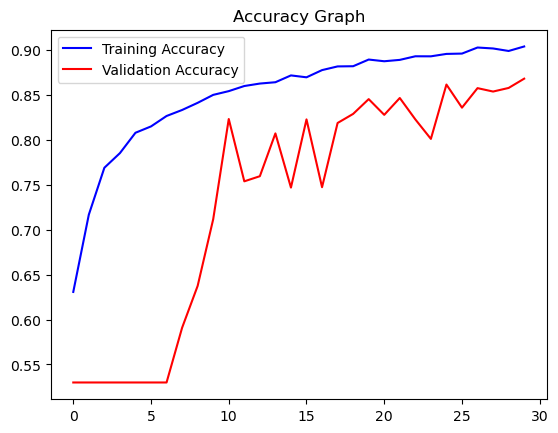

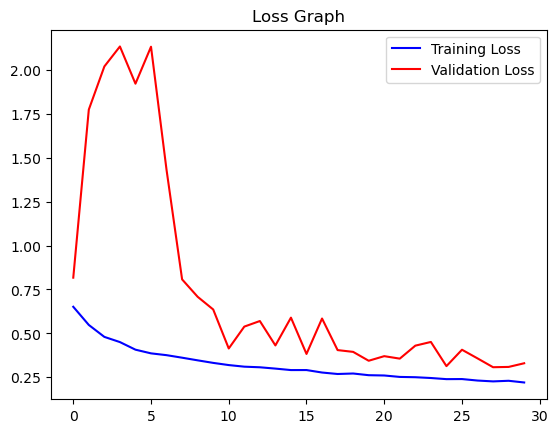

In [22]:
acc = history.history['gender_prediction_accuracy']
val_acc = history.history['val_gender_prediction_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_prediction_loss']
val_loss = history.history['val_gender_prediction_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

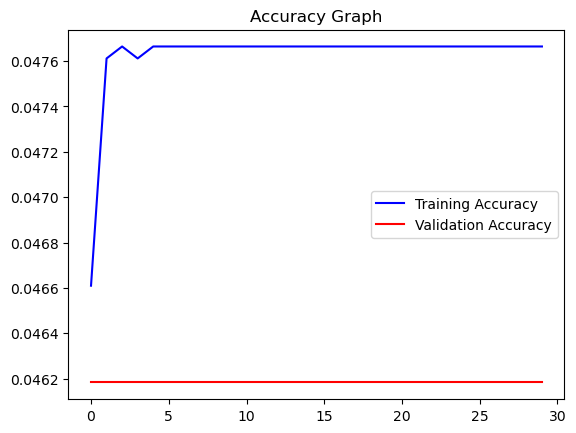

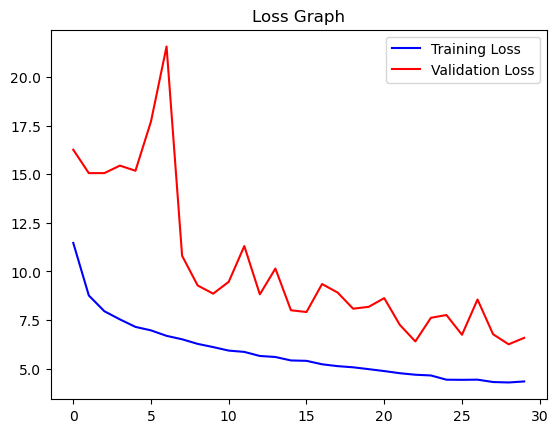

In [23]:
acc = history.history['age_prediction_accuracy']
val_acc = history.history['val_age_prediction_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['age_prediction_loss']
val_loss = history.history['val_age_prediction_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender male
Original Age 16.0
1/1 [==============================] - 1s 915ms/step
predicted_gender = male and age = 21


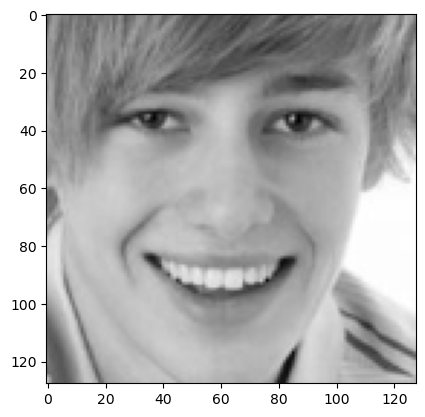

In [24]:
gender_dict = {0: "male", 1: "female"}

## Test the model
img_index = 53

print("Original Gender", gender_dict[Y_test_gender[img_index]])
print("Original Age", Y_test_age[img_index])

plt.imshow(X_test[img_index], cmap="gray")

pred = model.predict(X_test[img_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print(f"predicted_gender = {pred_gender} and age = {pred_age}")
# model.save_weights("model1.h5")

Original Gender female
Original Age 65.0
1/1 [==============================] - 0s 26ms/step
predicted_gender = female and age = 57


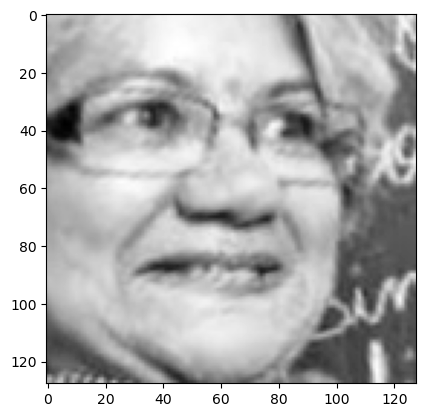

In [25]:
img_index = 400
print("Original Gender", gender_dict[Y_test_gender[img_index]])
print("Original Age", Y_test_age[img_index])

plt.imshow(X_test[img_index], cmap="gray")

pred = model.predict(X_test[img_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print(f"predicted_gender = {pred_gender} and age = {pred_age}")

Original Gender male
Original Age 7.0
1/1 [==============================] - 0s 25ms/step
predicted_gender = female and age = 11


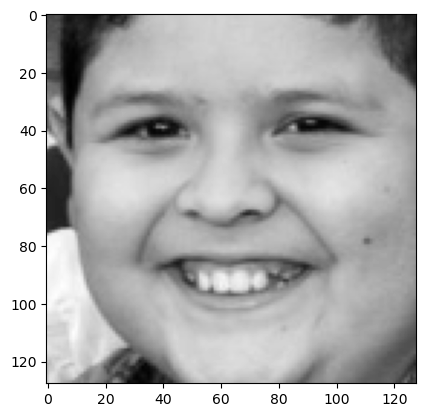

In [26]:
img_index = 250
print("Original Gender", gender_dict[Y_test_gender[img_index]])
print("Original Age", Y_test_age[img_index])

plt.imshow(X_test[img_index], cmap="gray")

pred = model.predict(X_test[img_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print(f"predicted_gender = {pred_gender} and age = {pred_age}")